# Neural Networks - SVM Loss Function and Gradient

## Import and Visualize CIFAR-10 Data Set

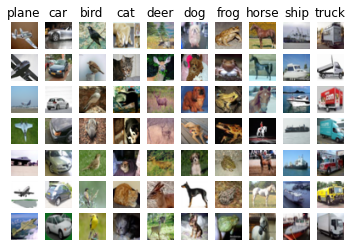

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# function to import CIFAR-10 data set
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data_batch_1 = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/data_batch_1")
data_batch_2 = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/data_batch_2")
data_batch_3 = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/data_batch_3")
data_batch_4 = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/data_batch_4")
data_batch_5 = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/data_batch_5")
test_batch = unpickle("/work/hslu-deep-learning/notebooks/Block 1/data/test_batch")

# Let us concatenate the batch training data 
X_train=np.concatenate([data_batch_1[b'data'], 
                         data_batch_2[b'data'], 
                         data_batch_3[b'data'], 
                         data_batch_4[b'data'], 
                         data_batch_5[b'data']], 
                         axis = 0)


# What is the shape of Xtr_rows ?
X_train.shape


# Let us concatenate the training labels
y_train=np.concatenate([data_batch_1[b'labels'] , 
                data_batch_2[b'labels'],
                data_batch_3[b'labels'],
                data_batch_4[b'labels'],
                data_batch_5[b'labels']], 
                axis = 0)

# Let us define the test data as X_test
X_test=test_batch[b'data']
X_test.shape

# Let us cast the test labels as ndarray
y_test=np.array(test_batch[b'labels']) 
y_test.shape


# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7



for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((3,32,32)).transpose((1,2,0)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

 ## Preprocessing the Data : Subtract the Mean Image

[130 130 130 131 132 132 133 133 134 134]


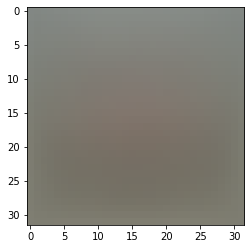

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [30]:
# First: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0).astype('uint8')
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
# visualize the mean image
plt.imshow(mean_image.reshape((3,32,32)).transpose((1,2,0))) 
plt.show()

# Second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


# Third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)


## SVM Loss Function and Gradient (Not Vectorized)

In [31]:
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
    To be precise: it is the Jacobian matrix of L with respect to all 
    matrix elements of W : dW is shorthand notation for dL/dW_ij
  """
  

  
  # initialize the gradient as zero
  dW = np.zeros(W.shape) 
  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
      scores = X[i].dot(W)
      correct_class_score = scores[y[i]]
      diff_count = 0  
      for j in range(num_classes):
          margin = scores[j] - correct_class_score + 1
          if j == y[i]:
              continue
          if margin > 0:
              diff_count += 1
              # gradient update for incorrect rows
              dW[:, j] += X[i] 
              loss += margin
      # gradient update for correct row
      dW[:, y[i]] += -diff_count * X[i]

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train
  dW += reg*W # regularize the weights
  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W)     
  
  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W)

  return loss, dW





# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))


loss: 9.524765


#  Gradient Check

We compute numerically the gradient along several randomly chosen 
dimensions, and compare them with our analytically computed gradient. 
The numbers should match almost exactly along all dimensions.

In [32]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical values
  in this dimensions.
  - f : is the loss function which will be passed to grad_check_sparse 
  as a lambda function
  - x : is the array containing the weight matrix
  - num_checks : how many elements of the array are randomly sampled
  """

  for i in range(num_checks):
    ix = tuple([np.random.randint(m) for m in x.shape])

    oldval = x[ix]
    # increment by h
    x[ix] = oldval + h 
    # evaluate f(x + h)
    fxph = f(x)
    # increment by h
    x[ix] = oldval - h 
    # evaluate f(x - h)
    fxmh = f(x) 
    # reset
    x[ix] = oldval 

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?

loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -50.477261 analytic: -50.622000, relative error: 1.431648e-03
numerical: -1.795996 analytic: -1.790000, relative error: 1.672047e-03
numerical: 55.391832 analytic: 55.288000, relative error: 9.381257e-04
numerical: -26.967832 analytic: -26.902000, relative error: 1.222049e-03
numerical: 33.095996 analytic: 33.084000, relative error: 1.812626e-04
numerical: -34.094832 analytic: -33.992000, relative error: 1.510301e-03
numerical: 17.840000 analytic: 17.840000, relative error: 5.665324e-12
numerical: 79.316000 analytic: 79.316000, relative error: 1.285348e-12
numerical: 23.174000 analytic: 23.174000, relative error: 1.013790e-11
numerical: 48.145081 analytic: 48.148000, relative error: 3.030900e-05
numerical: 32.292644 analytic: 32.434191, relative error: 2.186841e-03
numerical: 18.595902 analytic: 18.603951, relative error: 2.163774e-04
numerical: 49.828929 analytic: 49.799966, relative error: 2.907024e-04
numerical: -9.053657 analytic: -8.914913, relative error: 7.721512e-03


## SVM Loss Function and Gradient (Vectorized)

We implement the function `svm_loss_vectorized`; we compute
the loss and the gradient by means of vectorized operations

In [33]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
    Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  loss = 0.0
  delta = 1
  # initialize the gradient as zero
  dW = np.zeros(W.shape) 
  # compute the loss 
  num_train = X.shape[0]
  scores = X.dot(W)
  correct_class_score = scores[np.arange(num_train), y]
  margin = scores - correct_class_score[:, np.newaxis] + delta
  margin[np.arange(num_train), y] = 0
  margin = np.where(margin > 0, margin, 0)
  loss = np.sum(margin)/num_train
  # regularization
  loss += 0.5 * reg * np.sum(W * W) 
  
  # Compute the gradient : fully vectorized version 
  mask = np.zeros(margin.shape)
  # column maps to class, row maps to sample; a value v in X_mask[i, j]
  # adds a row sample i to column class j with multiple of v
  mask[margin > 0] = 1
  # for each sample, find the total number of classes where margin > 0
  incorrect_counts = np.sum(mask, axis=1)
  mask[np.arange(num_train), y] = -incorrect_counts
  dW = X.T.dot(mask)

  dW /= num_train # average out weights
  dW += reg*W # regularize the weights
  

  return loss, dW

### Check Correctness and Performance of Vectorized Gradient Computation

In [34]:
import time

tic = time.time()
loss_naive, _ = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))


tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))


# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Alternative time measurement with ipython : use %timeit
%timeit svm_loss_vectorized(W, X_dev, y_dev, 0.00001)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss: 9.524765e+00 computed in 0.130793s
Vectorized loss: 9.524765e+00 computed in 0.003474s
difference: 0.000000
Naive loss and gradient: computed in 0.089280s
Vectorized loss and gradient: computed in 0.003155s
2.39 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
difference: 0.000000


# Linear Classifier with Stochastic Gradient Descent (SGD)

iteration 0 / 1500: loss 796.467133
iteration 100 / 1500: loss 288.813947
iteration 200 / 1500: loss 112.093123
iteration 300 / 1500: loss 47.003432
iteration 400 / 1500: loss 21.543203
iteration 500 / 1500: loss 15.474673
iteration 600 / 1500: loss 12.437557
iteration 700 / 1500: loss 10.859243
iteration 800 / 1500: loss 13.143675
iteration 900 / 1500: loss 12.065388
iteration 1000 / 1500: loss 11.266365
iteration 1100 / 1500: loss 9.517066
iteration 1200 / 1500: loss 11.927069
iteration 1300 / 1500: loss 11.840023
iteration 1400 / 1500: loss 10.438228
That took 4.530363s


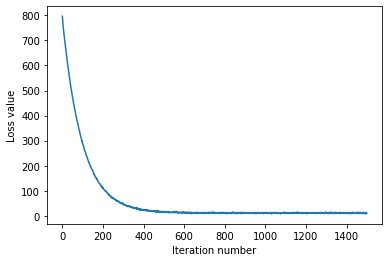

training accuracy: 0.157653
validation accuracy: 0.158000


In [35]:

class LinearClassifier():

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    # assume y takes values 0...K-1 where K is number of classes
    num_classes = np.max(y) + 1 
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      
      # Sample batch_size elements from the training data and their           
      # corresponding labels to use in this round of gradient descent.        
      # Store the data in X_batch and their corresponding labels in           
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   
      # and y_batch should have shape (batch_size,)                           
      #                                                                       
      # Use np.random.choice to generate indices. Sampling with         
      # replacement is faster than sampling without replacement.              
     
      sample_indices = np.random.choice(np.arange(num_train), batch_size)
      X_batch = X[sample_indices]
      y_batch = y[sample_indices]
      

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      
      # Update the weights using the gradient and the learning rate.          
      
      self.W += -learning_rate * grad
     

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
   
    # Implement this method. Store the predicted labels in y_pred.            
    
    y_pred = np.argmax(X.dot(self.W), axis=1)

    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses (child class) will override this.
    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.
    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass

class LinearSVM(LinearClassifier):
  """ A subclass (child class) that uses the Multiclass SVM loss function 
      The function loss of the parent class LinearClassifier will be 
      overwritten by the following loss function.
  """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)




svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))


# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()


# Evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

##  Tune the Hyperparameters Learning Rate and Regularization Strength

Use the validation set to tune hyperparameters (regularization strength and
learning rate). You should experiment with different ranges for the learning
rates and regularization strengths; if you are careful you should be able to
get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]

In [36]:
learning_rates = np.logspace(-5, 0, 40) 
# causes numeric issues: np.logspace(-5, 5, 8) #[-4, -3, -2, -1, 1, 2, 3, 4, 5, 6]
regularization_strengths = np.logspace(-5, 2, 40) 

`results` is dictionary mapping tuples of the form
(`learning_rate`, `regularization_strength`) to tuples of the form
(training_accuracy, validation_accuracy). The accuracy is simply the fraction
of data points that are correctly classified.

In [37]:
results = {}

The highest validation accuracy that we have seen so far.

In [38]:
best_val = -1

The LinearSVM object that achieved the highest validation rate. 

In [39]:
best_svm = None

The corresponding learning rates and regularization strengths

In [40]:
best_l = np.min(learning_rates)
best_r = np.min(regularization_strengths)

Code that chooses the best hyperparameters by tuning on the validation 
set. For each combination of hyperparameters, we train a linear SVM on the      
training set, compute its accuracy on the training and validation sets, and  
store these numbers in the results dictionary. In addition, we store the best   
validation accuracy in `best_val` and the LinearSVM object that achieves this  
accuracy in `best_svm`.                                                        
                                                                             
Hint: You should use a small value for `num_iters` as you develop your         
validation code so that the SVMs don't take much time to train; once you are 
confident that your validation code works, you should rerun the validation   
code with a larger value for `num_iters`.                         

In [ ]:
for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=l, reg=r, num_iters=1500, batch_size=200)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(l, r)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            best_l = l
            best_r = r

In [ ]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

## Visualize the cross-validation results

### Plot training accuracy

In [ ]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100 # default size of markers is 20
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

### Plot validation accuracy

In [ ]:
colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

### Evaluate the best svm on test set

In [ ]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)


### Rerun the training with larger value of num_iters

In [ ]:
svm = LinearSVM()
svm.train(X_train, y_train, learning_rate=best_l, reg=best_r, num_iters=3000, batch_size=200)
y_train_pred = svm.predict(X_train)
y_val_pred = svm.predict(X_val)
training_accuracy = np.mean(y_train == y_train_pred)
validation_accuracy = np.mean(y_val == y_val_pred)
if validation_accuracy > best_val:
    best_svm = svm

### Evaluate the new best svm on test set


In [ ]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

Visualize the learned weights for each class.
Depending on your choice of learning rate and regularization strength, these may
or may not be nice to look at.

In [ ]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.T.reshape(10,3,32,32).transpose(2,3,1,0)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

# Softmax Linear Classifier : Not Vectorized

In [ ]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength
  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  
  # Compute the softmax loss and its gradient using explicit loops.     
  # Store the loss in loss and the gradient in dW. If you are not careful     
  # here, it is easy to run into numeric instability. Don't forget the        
  # regularization!                                                           
  
  num_train = X.shape[0]
  num_classes = W.shape[1]
  loss = 0.0
  for i in range(num_train):
    # Compute vector of scores
    f_i = X[i].dot(W)

    # Normalization trick to avoid numerical instability
    f_i -= np.max(f_i)

    # Compute loss (and add to it, divided later)
    sum_j = np.sum(np.exp(f_i))
    p = lambda k: np.exp(f_i[k]) / sum_j
    loss += -np.log(p(y[i]))

    # Compute gradient
    # Here we are computing the contribution to the inner sum for a given i.
    for k in range(num_classes):
      p_k = p(k)
      dW[:, k] += (p_k - (k == y[i])) * X[i]

  loss /= num_train
  loss += 0.5 * reg * np.sum(W * W)
  dW /= num_train
  dW += reg*W


  return loss, dW





import time

# Generate a random softmax weight matrix and use it 
# to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))


# Loss and gradient computed in none vectorized fashion
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.




f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Softmax Loss and Gradient : Vectorized Operations

Now that we have a naive implementation of the softmax loss function and its gradient,
we implement a vectorized version in `softmax_loss_vectorized`.
The two versions should compute the same results, but the vectorized version should be
much faster.

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  
  # Compute the softmax loss and its gradient using no explicit loops.  
  # Store the loss in loss and the gradient in dW. If you are not careful     
  # here, it is easy to run into numeric instability. Don't forget the        
  # regularization!                                                           
 
  num_train = X.shape[0]
  f = X.dot(W)
  f -= np.max(f, axis=1, keepdims=True) # max of every sample
  sum_f = np.sum(np.exp(f), axis=1, keepdims=True)
  p = np.exp(f)/sum_f

  loss = np.sum(-np.log(p[np.arange(num_train), y]))

  ind = np.zeros_like(p)
  ind[np.arange(num_train), y] = 1
  dW = X.T.dot(p - ind)

  loss /= num_train
  loss += 0.5 * reg * np.sum(W * W)
  dW /= num_train
  dW += reg*W


  return loss, dW

# Linear Classifier : Softmax

In [ ]:
class Softmax(LinearClassifier):
  """ Softmax is a
  
  subclass (child class) that uses the 
      Softmax + Cross-entropy loss function and 
      overrides the loss function of the superclass 
      (parent class) LinearClassifier.
   """

  def loss(self, X_batch, y_batch, reg):
      return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)




tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))


tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

# Tune the Hyperparameters : Learning Rate and Regularization Strength

Use the validation set to tune hyperparameters (regularization strength and
learning rate). You should experiment with different ranges for the learning
rates and regularization strengths; if you are careful you should be able to
get a classification accuracy of over 0.35 on the validation set.

Use the validation set to set the learning rate and regularization strength. 
This should be identical to the validation that you did for the SVM; save    
the best trained softmax classifer in best_softmax.                          


In [ ]:
results = {}
best_val = -1
best_softmax = None
# np.logspace(-10, 10, 8) #-10, -9, -8, -7, -6, -5, -4
learning_rates = np.logspace(-10, 10, 10) 
# causes numeric issues: np.logspace(-5, 5, 8) #[-4, -3, -2, -1, 1, 2, 3, 4, 5, 6]
regularization_strengths = np.logspace(-3, 6, 10) 

iters = 1500
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax

##  Print out results

In [ ]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

## Evaluate on test set
Evaluate the best softmax on test set

In [ ]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

## Visualize the learned weights for each class

In [ ]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.T.reshape(10, 3, 32, 32).transpose(2,3,1,0)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])